# THE SPARKS FOUNDATION : GRADUATE ROTATIONAL INTERNSHIP PROGRAM (GRIP), FEBRUARY 2024

# Domain - Computer Vision and Internet of Things

## PROBLEM STATEMENT

## INTERNSHIP TASK 2: Detection of Face Mask

Data Source - https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

Implement a real-time face mask detector

## SOLUTION

## AUTHOR : ARITRA BAG

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-dataset/data/without_mask/without_mask_3248.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2803.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_650.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2060.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_559.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_3273.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_124.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1849.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_139.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2137.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2438.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_553.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2661.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_966.jp

#### IMPORTING LIBRARIES

In [2]:
!pip install keras_tuner

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import seaborn as sns
import keras_tuner
import keras
import tensorflow as tf
import gc
import PIL

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from keras_tuner import RandomSearch
from keras_tuner.engine import hyperparameters

2024-02-16 23:21:09.095459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 23:21:09.095683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 23:21:09.238323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### IMPORTING THE IMAGESET WITH AUGMENTATIONS

In [4]:
height=64
width=64
batch_size=128
epochs=100

rs=1./255
rr=5
zr=0.1
sr=0.1
hsr=0.1
wsr=0.1
hf=True
vf=False
s=False

In [5]:
image_augmentation=ImageDataGenerator(rescale=rs,rotation_range=rr,zoom_range=zr,shear_range=sr,height_shift_range=hsr,width_shift_range=wsr,horizontal_flip=hf,vertical_flip=vf)
image_generator=image_augmentation.flow_from_directory('/kaggle/input/face-mask-dataset/data',target_size=(height,width),batch_size=batch_size,class_mode='categorical',shuffle=s)
images=np.concatenate([image_generator.next()[0] for i in range(image_generator.__len__())])
training_steps = images//batch_size
gc.collect()

Found 7553 images belonging to 2 classes.


53

#### CREATING A LABEL ARRAY

In [6]:
labels = []
path_masked = "/kaggle/input/face-mask-dataset/data/with_mask"
for (root,folders,files) in os.walk(path_masked):
    for i in range(len(files)):
        labels.append(1)
path_unmasked = "/kaggle/input/face-mask-dataset/data/without_mask"
for (root,folders,files) in os.walk(path_unmasked):
    for i in range(len(files)):
        labels.append(0)
labels = np.array(labels)
gc.collect()

0

#### EXPLORATORY ANALYSIS OF THE DATASET

In [7]:
print(images.shape)
print(labels.shape)

(7553, 64, 64, 3)
(7553,)


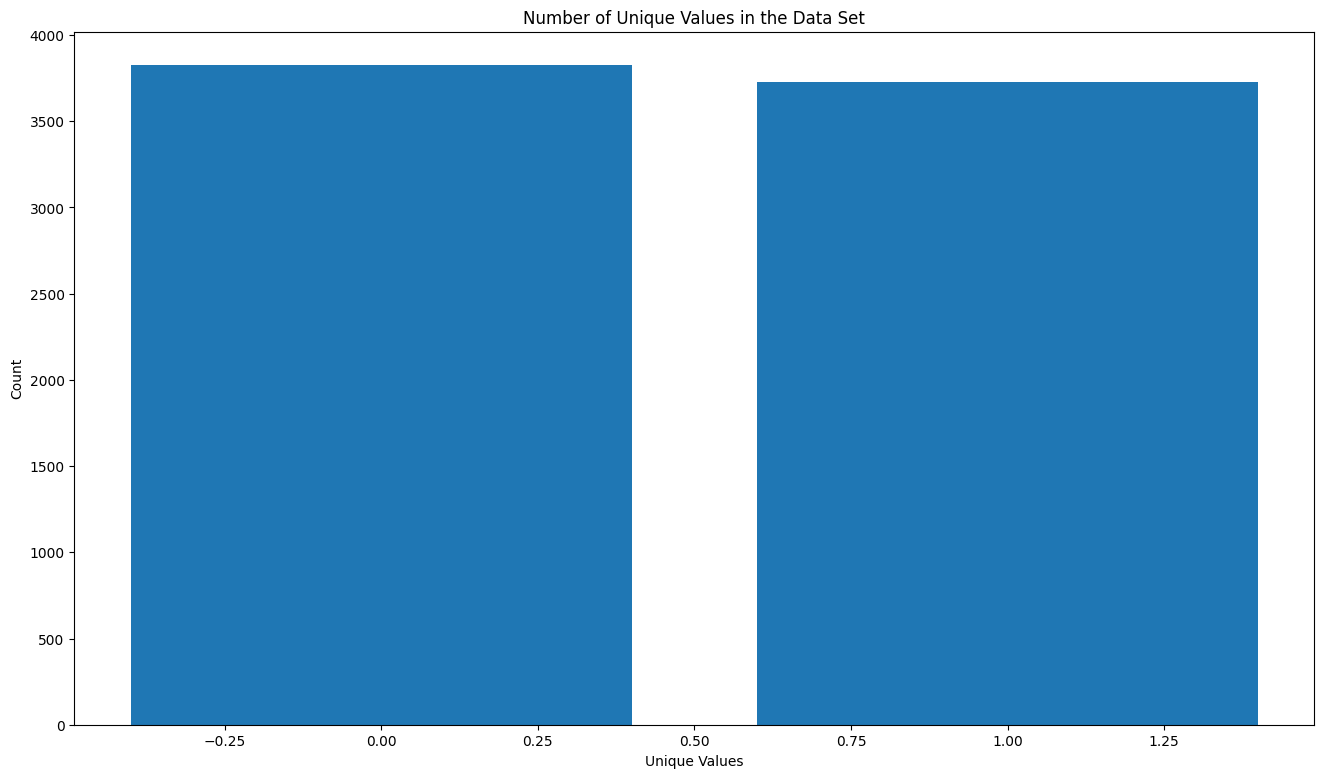

In [8]:
unique_values, counts = np.unique(labels, return_counts=True)
plt.figure(figsize = (16,9))
plt.bar(unique_values, counts)
plt.xlabel("Unique Values")
plt.ylabel("Count")
plt.title("Number of Unique Values in the Data Set")
plt.show()

In [9]:
def show_img(int):
    cap = labels[int]
    image = images[int]
    plt.figure(figsize = (4,4))
    plt.imshow(image)
    plt.xlabel(str(cap))
    plt.show

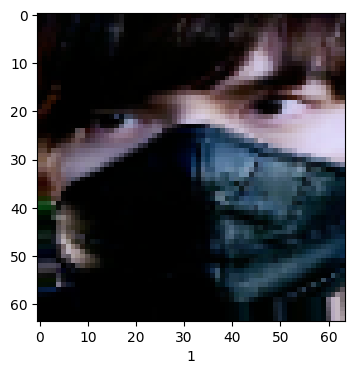

In [10]:
show_img(100)

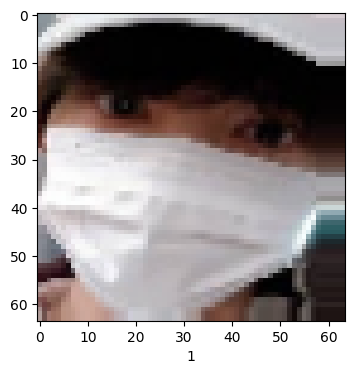

In [11]:
show_img(257)

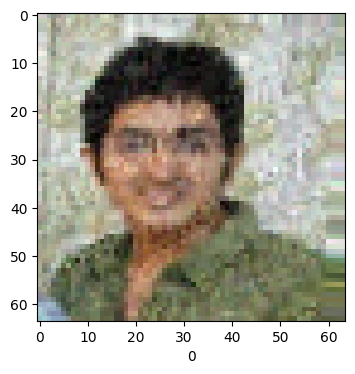

In [12]:
show_img(4056)

#### TRAIN TEST SPLIT

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=69, shuffle = True)
x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
gc.collect()

(6420, 64, 64, 3)
(1133, 64, 64, 3)
(6420,)
(1133,)


7069

#### GETTING THE BEST FIT MODEL

##### GETTING A PRE-TRAINED MODEL

In [15]:
pre_trained_model = keras.applications.MobileNetV2(input_shape=(height,width,3),include_top=False,weights='imagenet')
for layer in pre_trained_model.layers:
    layer.trainable=False

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
def build_model(hp):
    
    model = pre_trained_model.output
    
    model = GlobalAveragePooling2D()(model)
    
    model = (keras.layers.Dense(units=hp.Int('dense_1_units',min_value=8,max_value=1024,step=8),activation=hp.Choice('dense_1_activation',values=['relu', 'elu', 'selu']),kernel_initializer=hp.Choice('dense_1_kernel_initializer',values=['random_normal','glorot_normal', 'he_normal', 'glorot_uniform'])))(model)

    model = (keras.layers.Dropout(rate=hp.Float('dropout_1_rate',min_value=0.1,max_value=0.9,step=0.05)))(model)

    model = (keras.layers.Dense(units=hp.Int('dense_2_units',min_value=8,max_value=1024,step=8),activation=hp.Choice('dense_2_activation',values=['relu', 'elu', 'selu']),kernel_initializer=hp.Choice('dense_2_kernel_initializer',values=['random_normal','glorot_normal', 'he_normal', 'glorot_uniform'])))(model)

    model = (keras.layers.Dropout(rate=hp.Float('dropout_2_rate',min_value=0.1,max_value=0.9,step=0.05)))(model)

    model = (keras.layers.Dense(units=hp.Int('dense_3_units',min_value=8,max_value=1024,step=8),activation=hp.Choice('dense_3_activation',values=['relu', 'elu', 'selu']),kernel_initializer=hp.Choice('dense_3_kernel_initializer',values=['random_normal','glorot_normal', 'he_normal', 'glorot_uniform'])))(model)

    model = (keras.layers.Dropout(rate=hp.Float('dropout_3_rate',min_value=0.1,max_value=0.9,step=0.05)))(model)

    model = (keras.layers.Dense(units=hp.Int('dense_4_units',min_value=8,max_value=1024,step=8),activation=hp.Choice('dense_4_activation',values=['relu', 'elu', 'selu']),kernel_initializer=hp.Choice('dense_4_kernel_initializer',values=['random_normal','glorot_normal', 'he_normal', 'glorot_uniform'])))(model)

    model = (keras.layers.Dense(1,activation='sigmoid'))(model)
    
    trial_model = Model(pre_trained_model.input, model)

    trial_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3])),
                                          loss='binary_crossentropy',
                                          metrics=['accuracy'])

    return trial_model

In [17]:
tuner_search = RandomSearch(build_model,objective='val_accuracy', max_trials = 500, directory='output', project_name = 'face_mask_detection')
tuner_search.search(x_train, y_train,epochs = 5, batch_size = batch_size, validation_split=0.15)

Trial 500 Complete [00h 00m 23s]
val_accuracy: 0.9314641952514648

Best val_accuracy So Far: 0.9439252614974976
Total elapsed time: 02h 23m 57s


In [18]:
model = tuner_search.get_best_models(num_models=1)[0]
parameters=tuner_search.get_best_hyperparameters(1)[0]
print(parameters.values)

{'dense_1_units': 696, 'dense_1_activation': 'relu', 'dense_1_kernel_initializer': 'glorot_uniform', 'dropout_1_rate': 0.4, 'dense_2_units': 504, 'dense_2_activation': 'relu', 'dense_2_kernel_initializer': 'glorot_normal', 'dropout_2_rate': 0.7000000000000001, 'dense_3_units': 880, 'dense_3_activation': 'relu', 'dense_3_kernel_initializer': 'random_normal', 'dropout_3_rate': 0.25, 'dense_4_units': 928, 'dense_4_activation': 'selu', 'dense_4_kernel_initializer': 'random_normal', 'learning_rate': 0.001}


In [19]:
print(model.summary)
model_name='/kaggle/working/face_mask_detector.png'
keras.utils.plot_model(model, to_file=model_name, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, dpi=96, show_layer_activations=True, show_trainable=True, rankdir='TB')
gc.collect()

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x78aeb184a8f0>>


46959

In [20]:
face_mask_detector = model
face_mask_detector.fit(x_train, y_train, epochs = 15, batch_size = batch_size, validation_split = 0.15)
gc.collect()

Epoch 1/15
43/43 [==============================] - 6s 51ms/step - loss: 0.0859 - accuracy: 0.9665 - val_loss: 0.2002 - val_accuracy: 0.9304
Epoch 2/15
43/43 [==============================] - 1s 24ms/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 0.2455 - val_accuracy: 0.9304
Epoch 3/15
43/43 [==============================] - 1s 24ms/step - loss: 0.0605 - accuracy: 0.9786 - val_loss: 0.2388 - val_accuracy: 0.9283
Epoch 4/15
43/43 [==============================] - 1s 24ms/step - loss: 0.0581 - accuracy: 0.9813 - val_loss: 0.2831 - val_accuracy: 0.9304
Epoch 5/15
43/43 [==============================] - 1s 24ms/step - loss: 0.0397 - accuracy: 0.9861 - val_loss: 0.2907 - val_accuracy: 0.9263
Epoch 6/15
43/43 [==============================] - 1s 24ms/step - loss: 0.0513 - accuracy: 0.9844 - val_loss: 0.2697 - val_accuracy: 0.9346
Epoch 7/15
43/43 [==============================] - 1s 24ms/step - loss: 0.0280 - accuracy: 0.9885 - val_loss: 0.3470 - val_accuracy: 0.9325
Epoch 8/15
43

1358

#### EVALUATION OF THE CLASSIFIER

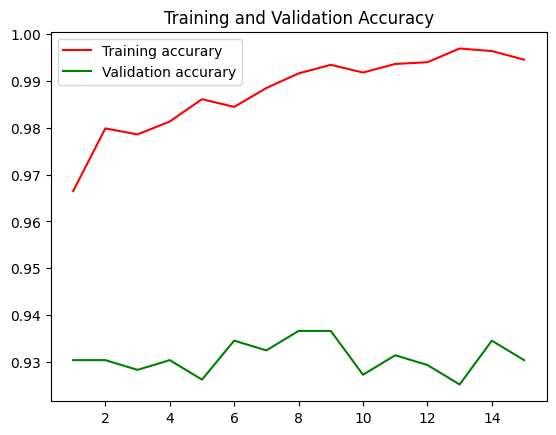

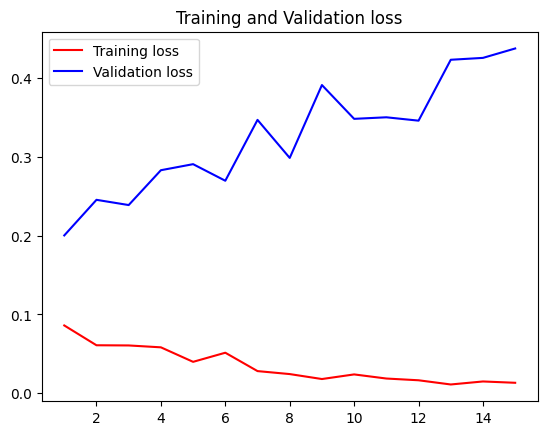

In [21]:
acc=face_mask_detector.history.history['accuracy']
val_acc=face_mask_detector.history.history['val_accuracy']
loss=face_mask_detector.history.history['loss']
val_loss=face_mask_detector.history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'r',label='Training accurary')
plt.plot(epochs,val_acc,'g',label='Validation accurary')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [22]:
y_probability=face_mask_detector.predict(x_test)
y_predict = np.where(y_probability > 0.5, 1,0)

36/36 [==============================] - 2s 21ms/step


The classification test results are : 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       574
           1       0.94      0.95      0.94       559

    accuracy                           0.95      1133
   macro avg       0.95      0.95      0.95      1133
weighted avg       0.95      0.95      0.95      1133



The test accuracy percentage is :
94.52780229479258


The test precision percentage is :
93.82716049382715


The test recall percentage is :
95.16994633273703


The test f1 percentage is :
94.49378330373001


The test ROC AUC percentage is :
0.9453619267856364
Confusion Matrix :


<Axes: >

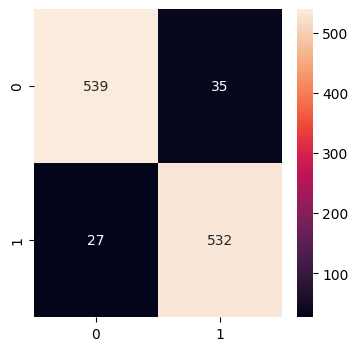

In [23]:
print('The classification test results are : \n')
print(classification_report(y_test,y_predict))
print('\n')
print('The test accuracy percentage is :')
print((accuracy_score(y_test,y_predict))*100)
print('\n')
print('The test precision percentage is :')
print((precision_score(y_test,y_predict))*100)
print('\n')
print('The test recall percentage is :')
print((recall_score(y_test,y_predict))*100)
print('\n')
print('The test f1 percentage is :')
print((f1_score(y_test,y_predict))*100)
print('\n')
print('The test ROC AUC percentage is :')
print(roc_auc_score(y_test,y_predict))

print('Confusion Matrix :')
cm=confusion_matrix(y_test,y_predict)
plt.figure(figsize = (4,4))
sns.heatmap(cm, annot = True, fmt = 'g')

#### SAVING THE MODEL

In [24]:
face_mask_detector.save("/kaggle/working/face_mask_detector.h5")